# Plutonium Maker
The purpose of this notebook is to investigate the performance of various pin-cell configurations in producing weapons grade plutonium.

The sorts of questions that I want to be able to answer:
1. What are the trade-offs in moderator selection
2. What should be the fuel pitch, diameter and/or pitch to diameter ratio?
3. How long should the fuel be left in the reactor for maximum production of plutonium? 
4.  I expect the answer to 3 to depend on the power density and the neutron energy spectrum.  I assume you should just operate at the maximum achievable power density (with respect to heat transfer requirements) but how does the neutron energy spectrum change things?
5. If I wanted to make Pu-238, how would the reactor core design change. (fuel, moderator, coolant, geometric arrangement, etc...)

After some initial investigations, I can investigate the available design information for early plutonium production reactors.  As much as is possible, I could try to observe how plutonium production reactor core design has changed over the years and try to infer the engineering rationale for the evolution. 

In short: I hope to build a *quantitative* intuition regarding these considerations.


In [1]:
import openmc
import numpy as np

%matplotlib inline

## Materials


In [2]:
fuel = openmc.Material(name="uo2")
fuel.add_element("U", 1, percent_type="ao", enrichment=0.7)
#fuel.add_element("O", 2)
fuel.set_density("g/cc", 18.4)

clad = openmc.Material(name='clad');
clad.add_element("Zr",1);
clad.set_density('g/cc',6.0);

alum = openmc.Material(name='alum');
alum.add_element('Al',1);
alum.set_density('g/cc',2.7); #according to Google...

water = openmc.Material(name='water');
water.add_element('O',1);
water.add_element('H',2)
water.set_density('g/cc',0.712); # higher temperature water...
water.add_s_alpha_beta('c_H_in_H2O');

graphite = openmc.Material(name='graphite');
graphite.add_element('C',1);
graphite.set_density('g/cc',1.7);
graphite.add_s_alpha_beta('c_Graphite');

materials = openmc.Materials([fuel,clad,water,alum,graphite]);
materials.export_to_xml();

## Geometry
I will make a pin cell.  In order to (roughly) model a hanford pin cell I will use a uranium metal slug coated with aluminum in a graphite reflector cooled with water. 

In [3]:
h_core = 300.; # all dimensions in cm 
h_fuel = 200.;

r_fuel = 2.0;
r_pin = 2.1;
r_cool = 2.25;

P_D = 5.5; # with graphite moderator a relatively high P/D is needed for reasonable neutron economy
# 10 is too high, 3 is too low (0.889), 7 is too high again (0.974), 5.5 (.9959) 4.5 (0.9859), 5.0 (0.9935), 6.0 (0.9948)

# note that for P/D=5.5, if I eliminate the water from the cooling channel, keff jumps up to 1.0341 (!!)
# all of the above was with a fuel radius (without the clad) of 1 cm.

# when I increase the r_fuel to 2.0 with clad thickness and coolant channel "thickness" the same k_eff increases
# somewhat. Effectively this increases the atom fraction of fuel compared to coolant or cladding so it is likely to help.


pitch = P_D*r_cool*2.; # set P/D relative to the coolant channel diameter

# on later iterations add temperature effects to the fuel to see how important they are.

fuel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2.],
                                             h_fuel, r_fuel);
fuel.volume = np.pi*(r_fuel**2)*h_fuel;

pin_cyl = openmc.model.RightCircularCylinder([0.,0.,-(h_fuel+(r_pin-r_fuel))/2.],
                                            h_fuel+(r_pin-r_fuel)*2.,r_pin);

cool_ch_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_core/2.+5.],
                                                h_core-10.,r_cool);
# note: I added some margin between the coolant cell upper and lower boundaries and the core.
# having those surfaces coincident resulted in lost particles.

core_cell = openmc.model.RectangularParallelepiped(-pitch/2.,pitch/2.,
                                                  -pitch/2.,pitch/2.,
                                                  -h_core/2.,h_core/2.,
                                                  boundary_type='reflective');

fuel_cell = openmc.Cell();
fuel_cell.region = -fuel_cyl;
fuel_cell.fill = fuel;
fuel_cell.temperature = 800; #K, reminder to fill this in later

clad_cell = openmc.Cell();
clad_cell.region = +fuel_cyl & -pin_cyl
clad_cell.fill = clad;

cool_cell = openmc.Cell();
cool_cell.region = +pin_cyl & -cool_ch_cyl;
cool_cell.fill = water;

mod_cell = openmc.Cell();
mod_cell.region = +cool_ch_cyl & -core_cell;
mod_cell.fill = graphite;
mod_cell.temperature = 700; # K, just a guess




In [4]:
root_univ = openmc.Universe();
root_univ.add_cells([fuel_cell,clad_cell,cool_cell,mod_cell]);

geometry = openmc.Geometry();
geometry.root_universe = root_univ;

geometry.export_to_xml();


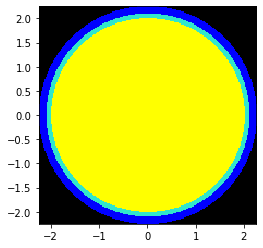

In [5]:
color = {}
color[fuel]='yellow';
color[alum]='gray';
color[water]='blue';
color[graphite]='black';

#root_univ.plot(width=(pitch,pitch),color_by='material',colors=color);
root_univ.plot(width=(2*r_cool,2*r_cool),color_by='material',colors=color);

## Settings
Initially we will just find what the eigenvalue is.  Since this will model a reactor that is infinite, the materials will need to be tweaked so that the eigenvalue is greater than 1.  

In [6]:
settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 4000;
settings.batches = 150;
settings.inactive = 50;

box = openmc.stats.Box(lower_left = (-r_fuel,-r_fuel,-h_fuel/2.),
                      upper_right = (r_fuel,r_fuel,h_fuel/2.),
                      only_fissionable=True);
src = openmc.Source(space=box);

settings.source = src;

settings.temperature['method']='interpolation';

settings.export_to_xml();


In [7]:
openmc.run();

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      135/1    1.00605    1.00529 +/- 0.00190
      136/1    1.02201    1.00548 +/- 0.00189
      137/1    1.00519    1.00548 +/- 0.00186
      138/1    1.01058    1.00554 +/- 0.00184
      139/1    0.99496    1.00542 +/- 0.00183
      140/1    0.97843    1.00512 +/- 0.00183
      141/1    1.00896    1.00516 +/- 0.00181
      142/1    0.97083    1.00479 +/- 0.00183
      143/1    1.00724    1.00481 +/- 0.00181
      144/1    1.00074    1.00477 +/- 0.00179
      145/1    0.99144    1.00463 +/- 0.00178
      146/1    1.00345    1.00462 +/- 0.00176
      147/1    0.96047    1.00416 +/- 0.00180
      148/1    0.99447    1.00406 +/- 0.00178
      149/1    1.01076    1.00413 +/- 0.00177
      150/1    0.96442    1.00373 +/- 0.00179
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 1.4422e+00 seconds
   Reading cross sections          = 1.4287e+00 seconds
 Total time in simulation     

## Depletion Calculation
Okay - this is a start.  I fully expect that the reactor, as modeled, will not remain critical once equilibrium Xe-135 and Sm-149 are established in the core.  The negative reactivity from the doppler broadening of the fuel didn't turn out to be such a big deal.

In [8]:
import openmc.deplete

operator = openmc.deplete.Operator(geometry,settings,"chain_casl_pwr.xml");
power = 1e4; # W, this is a guess

operator.heavy_metal

max_step = 2*operator.heavy_metal/power*1e3
print(f'Maximum recommended depletion step %5.3f days' % max_step);

Maximum recommended depletion step 9248.849 days


In [9]:

days = 24*3600; # seconds in a day
time_steps = [0.1*days,0.1*days,0.2*days,0.3*days,0.5*days,
              1.0*days,10.0*days, 100.0*days, 100.0*days, 200.*days,
             200.*days, 200.*days, 500.*days, 500.*days];


In [10]:
integrator = openmc.deplete.PredictorIntegrator(operator,time_steps,power=power);
#integrator = openmc.deplete.CELIIntegrator(operator,time_steps,power=power);

In [11]:
integrator.integrate()

In [12]:
results = openmc.deplete.ResultsList.from_hdf5("./depletion_results.h5")

In [13]:
time, k = results.get_eigenvalue()

In [14]:
time /= (24*3600);

In [15]:
from matplotlib import pyplot

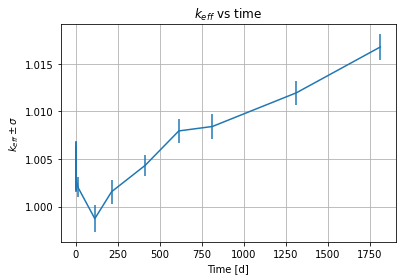

In [16]:
pyplot.errorbar(time,k[:,0],yerr=k[:,1]);
pyplot.xlabel('Time [d]');
pyplot.ylabel('$k_{eff}\pm \sigma$');
pyplot.title("$k_{eff}$ vs time");
pyplot.grid();

obviously, these results suck.  A better analysis would use more particles at least and probably smaller time steps.

In [17]:
_time, pu239 = results.get_atoms("1","Pu239");
_time, pu240 = results.get_atoms("1","Pu240");
_time, pu241 = results.get_atoms("1","Pu241");

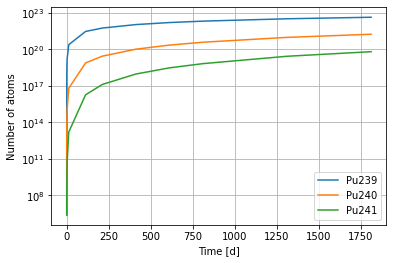

In [18]:
pyplot.semilogy(time,pu239,label="Pu239");
pyplot.semilogy(time,pu240,label="Pu240");
pyplot.semilogy(time,pu241,label="Pu241");
pyplot.grid();
pyplot.xlabel('Time [d]');
pyplot.ylabel('Number of atoms');
pyplot.legend();


In [19]:
mass_pu239 = pu239*(239./6.022e23);
mass_pu240 = pu240*(240./6.022e23);
mass_pu241 = pu241*(241./6.022e23);

mass_pu = mass_pu239 + mass_pu240 + mass_pu241

In [20]:
pu_239_ratio = mass_pu239/mass_pu

In [21]:
print(pu_239_ratio)

[0.33194444 0.99997289 0.9999703  0.99996558 0.99995983 0.99995093
 0.99993331 0.99973355 0.99738792 0.99503391 0.9903911  0.98579829
 0.98132707 0.9702453  0.95968948]


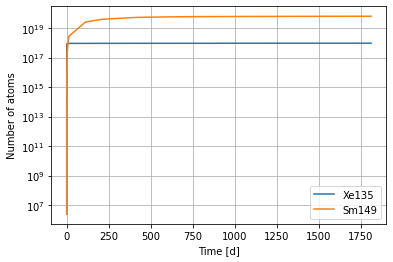

In [22]:
_time, xe135 = results.get_atoms("1","Xe135")
_time, sm149 = results.get_atoms("1","Sm149")

pyplot.semilogy(time,xe135,label="Xe135");
pyplot.semilogy(time,sm149,label="Sm149");
pyplot.grid();
pyplot.xlabel('Time [d]');
pyplot.ylabel('Number of atoms');
pyplot.legend();
